<a href="https://colab.research.google.com/github/torbenbillow/CBS-AML-PROJECT/blob/main/notebooks/00_welcome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [1]:
# ADD COMMENTS FOR EACH IMPORT TO EXPLAIN WHY WE NEED IT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, max_error, mean_absolute_percentage_error)

from google.colab import drive
pd.options.mode.copy_on_write = True # WHAT DO THIS DO?

# LOAD DATA FROM GOOGLE DRIVE

In [2]:
print("Loading raw data from Google Drive location...")
file_id = "1Iyr7zX8u0gKWKUWCSgZUpcvbTuYBmw1V"             # File id from Google Drive
url = f"https://drive.google.com/uc?id={file_id}"         # URL to Google Sheet with the inputted file_id
listings_raw = pd.read_csv(url)                           # Store the data in the "listings_raw" variable

print("Raw data successfully loaded.")

print("Raw dataframe shape:",listings_raw.shape)          # Print the shape of the dataframe so we have a baseline

Loading raw data from Google Drive location...
Raw data successfully loaded.
Raw dataframe shape: (22684, 79)


# DATA WRANGLING

## DISPLAY ALL RAW DATA COLUMNS AND MANUALLY REMOVE UNWANTED (DOMAIN KNOWLEDGE)

In [3]:
# Copy the original dataframe to the df variable, so the original data set can be used for comparisons
df = listings_raw.copy()

# List all columns
list(df)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [4]:
# The following columns are irrelevant, and thus, we have chosen to drop them.
df = df.drop(columns=["listing_url","scrape_id","source","host_id","host_url","calendar_last_scraped","first_review","host_neighbourhood"])

# The following columns could impact a listing's "success" (discrimination based on a name or picture, for example), but due
# to the complexity of including them, and the scope of this project, we have chosen to drop them.
df = df.drop(columns=["name","picture_url","host_name","host_thumbnail_url","host_picture_url"])

# Dropping the following columns in favor of "calculated_host_listings_count," because that is the direct calculation of how many listings
# a host has at the time of scrape. The metadata also notes that the following calculations are "unknown," and thereby less trustworthy.
df = df.drop(columns=["host_listings_count","host_total_listings_count"])

# Dropping in favor of "host_identitity_verified," which is a boolean that indicates whether or not the host is verified.
df = df.drop(columns=["host_verifications"])

# Dropping in favor of "neighborhood_cleansed."
df = df.drop(columns=["neighbourhood"])

# Dropping the following, as they are completely empty attributes.
df = df.drop(columns=["neighbourhood_group_cleansed","calendar_updated","license"])

# Dropping the following columns in favor of "mini_nights" and "maximum_nights."
df = df.drop(columns=["minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm"])

# Dropping the following columns, because there is no information about they represent.
df = df.drop(columns=["has_availability","availability_eoy"])

''' Dropping the following columns, because we have selected "availability_30" as our target variable. We believe this the most accurate
indicator of a listing's popularity/success, because listings will on average be booked more in the short term than in the long term.
We would be able to attribute the availability to an actual "interest level," rather than a lack of booking simply due to time considerations.
Seasonality should not matter since the scope of our listings is limited to Copenhagen, so theoretically, all listings would be impacted equally
by seasonality. '''
df = df.drop(columns=["availability_60","availability_90","availability_365"])

# Dropping the following columns in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ltm","number_of_reviews_l30d"])

# Dropping in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ly"])

# Irrelevant and would introduce data leakage.
df = df.drop(columns=["estimated_revenue_l365d"])

# Dropping the following attributes because they will not be available at the time of prediction.
df = df.drop(columns=["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])

# Dropping the following columns in favor of "calculated_host_listings_count" for simplicity.
df = df.drop(columns=["calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"])

# Dropping in favor of "number_of_reviews."
df = df.drop(columns=["reviews_per_month"])


In [5]:
# Print size of dataframe before drops
print("Dataframe shape before column drops:",listings_raw.shape)

# Print size of dataframe after drops
print("Dataframe shape after column drops:",df.shape)

print("\n")
print("Number of columns removed:",listings_raw.shape[1] - df.shape[1])
print("Number of rows removed:",listings_raw.shape[0] - df.shape[0])

Dataframe shape before column drops: (22684, 79)
Dataframe shape after column drops: (22684, 33)


Number of columns removed: 46
Number of rows removed: 0


## AUDIT THE DATA TO DETERMINE WHAT NEEDS TO BE CLEANSED

In [6]:
# Create a function that will audit the data and provide an overview, making it easier to systematically determine what needs to be cleansed.

def audit_dataframe(df, name="DataFrame"):
    print(f"\n=== AIRBNB DATA AUDIT: {name} ===\n")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # ----- SHOW NULL SUMMARY -----
    print("---- Missing Values ----")
    nulls = df.isnull().sum()
    nulls_percent = (df.isnull().mean() * 100).round(2)
    null_summary = pd.DataFrame({
        "null_count": nulls,
        "null_percent": nulls_percent,
        "dtype": df.dtypes
    })
    display(null_summary[nulls > 0].sort_values("null_percent", ascending=False))
    print("\n")

    # ----- SHOW DATA TYPES -----
    print("---- Data Types ----")
    data_types = df.dtypes.rename("dtype").to_frame()
    display(data_types)

    print("\n")

    # ----- SHOW DESCRIPTIVE STATS -----
    print("---- Descriptive Statistics (Numerical) ----")
    display(df.describe(include=[np.number]).transpose().round(2))
    print("\n")

    print("---- Descriptive Statistics (Categorical) ----")
    display(df.describe(include=['object', 'category']).transpose())
    print("\n")

    # ----- SHOW UNIQUE VALUES -----
    print("---- Unique Value Counts ----")
    unique_counts = (df.nunique().sort_values().rename("unique_counts").to_frame())
    display(unique_counts)
    print("\n")

    # ----- SHOW SAMPLE VALUES FOR EACH COLUMN -----
    print("---- Sample Values ----")
    display(df.sample(5))
    print("\n")

    # ----- SHOW BOOLEAN DISTRIBUTION -----
    print("---- Boolean Column Distributions ----")
    bool_cols = df.select_dtypes(include=["bool","boolean"]).columns
    if len(bool_cols) > 0:
        bool_summary = []

        for col in bool_cols:
            vc = df[col].value_counts(dropna=False)
            true_count = vc.get(True, 0)
            false_count = vc.get(False, 0)
            na_count = vc.get(pd.NA, 0) if "boolean" in str(df[col].dtype) else 0
            total = len(df[col])

            bool_summary.append({
                "column": col,
                "dtype": df[col].dtype,
                "true_count": true_count,
                "false_count": false_count,
                "na_count": na_count,
                "true_percent": round(true_count / total * 100, 2),
                "false_percent": round(false_count / total * 100, 2),
                "na_percent": round(na_count / total * 100, 2),
            })

        display(pd.DataFrame(bool_summary))

    else:
        print("NO BOOLEAN COLUMNS FOUND")

    print("\n")

    # ----- SHOW CATEGORICAL CARDINALITY -----
    print("---- Categorical Cardinality ----")

    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    cardinality_df = pd.DataFrame({
        "column": cat_cols,
        "unique_values": [df[col].nunique() for col in cat_cols]
    })
    display(cardinality_df)
    print("\n")

    # ----- SHOW DUPLICATES -----
    print("---- Duplicate Rows ----")

    dupes = df.duplicated().sum()
    duplicate_df = pd.DataFrame({"duplicate_rows": [dupes]})
    display(duplicate_df)
    print("\n")

    print("=== END AUDIT ===\n")


In [7]:
# Run the function to show the various metrics defined

audit_dataframe(df, name="Airbnb Data")


=== AIRBNB DATA AUDIT: Airbnb Data ===

Shape: 22684 rows × 33 columns

---- Missing Values ----


null_count  null_percent    dtype
neighborhood_overview        14459         63.74   object
host_about                   13381         58.99   object
bathrooms                     8858         39.05  float64
beds                          8856         39.04  float64
price                         8853         39.03   object
host_response_time            7853         34.62   object
host_response_rate            7853         34.62   object
host_acceptance_rate          5288         23.31   object
host_location                 4082         18.00   object
last_review                   3146         13.87   object
bedrooms                       716          3.16  float64
description                    614          2.71   object
host_since                     529          2.33   object
host_identity_verified         529          2.33   object
host_has_profile_pic           529          2.33   object
host_is_superhost              238          1.05   object
bathrooms_text                   8          0.04   object



---- Data Types ----


dtype
id                                int64
last_scraped                     object
description                      object
neighborhood_overview            object
host_since                       object
host_location                    object
host_about                       object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
host_is_superhost                object
host_has_profile_pic             object
host_identity_verified           object
neighbourhood_cleansed           object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
minimum_nights                    int64
maximum_nights                    int64
availability_30                   int64
number_of_reviews                 int64
estimated_occupancy_l365d         int64
last_review                      object
instant_bookable                 object
calculated_host_listings_count    int64



---- Descriptive Statistics (Numerical) ----


count          mean           std       min  \
id                              22684.0  6.582521e+17  5.448303e+17  29118.00   
latitude                        22684.0  5.568000e+01  2.000000e-02     55.62   
longitude                       22684.0  1.256000e+01  3.000000e-02     12.45   
accommodates                    22684.0  3.330000e+00  1.640000e+00      1.00   
bathrooms                       13826.0  1.100000e+00  3.400000e-01      0.00   
bedrooms                        21968.0  1.620000e+00  8.900000e-01      0.00   
beds                            13828.0  1.870000e+00  1.270000e+00      0.00   
minimum_nights                  22684.0  4.640000e+00  1.778000e+01      1.00   
maximum_nights                  22684.0  3.055400e+02  3.767400e+02      1.00   
availability_30                 22684.0  6.140000e+00  8.670000e+00      0.00   
number_of_reviews               22684.0  1.893000e+01  4.594000e+01      0.00   
estimated_occupancy_l365d       22684.0  3.166000e+01  4.988000e+01      0.00   
calculated_host_listings_count  22684.0  4.870000e+00  2.687000e+01      1.00   

                                        25%           50%           75%  \
id                              36348049.75  7.954608e+17  1.157326e+18   
latitude                              55.67  5.568000e+01  5.570000e+01   
longitude                             12.54  1.256000e+01  1.258000e+01   
accommodates                           2.00  3.000000e+00  4.000000e+00   
bathrooms                              1.00  1.000000e+00  1.000000e+00   
bedrooms                               1.00  1.000000e+00  2.000000e+00   
beds                                   1.00  1.000000e+00  2.000000e+00   
minimum_nights                         2.00  3.000000e+00  4.000000e+00   
maximum_nights                        20.00  9.000000e+01  3.650000e+02   
availability_30                        0.00  1.000000e+00  9.000000e+00   
number_of_reviews                      2.00  7.000000e+00  1.900000e+01   
estimated_occupancy_l365d              0.00  1.200000e+01  4.000000e+01   
calculated_host_listings_count         1.00  1.000000e+00  1.000000e+00   

                                         max  
id                              1.451628e+18  
latitude                        5.573000e+01  
longitude                       1.264000e+01  
accommodates                    1.600000e+01  
bathrooms                       8.000000e+00  
bedrooms                        9.000000e+00  
beds                            1.600000e+01  
minimum_nights                  1.111000e+03  
maximum_nights                  1.125000e+03  
availability_30                 3.000000e+01  
number_of_reviews               2.366000e+03  
estimated_occupancy_l365d       2.550000e+02  
calculated_host_listings_count  2.470000e+02



---- Descriptive Statistics (Categorical) ----


count unique  \
last_scraped            22684      6   
description             22070  21430   
neighborhood_overview    8225   7901   
host_since              22155   4729   
host_location           18602    333   
host_about               9303   7736   
host_response_time      14831      4   
host_response_rate      14831     91   
host_acceptance_rate    17396    101   
host_is_superhost       22446      2   
host_has_profile_pic    22155      2   
host_identity_verified  22155      2   
neighbourhood_cleansed  22684     11   
property_type           22684     55   
room_type               22684      4   
bathrooms_text          22676     21   
amenities               22684  21560   
price                   13831   2496   
last_review             19538   1742   
instant_bookable        22684      2   

                                                                      top  \
last_scraped                                                   2025-07-01   
description             Your family will be close to everything when y...   
neighborhood_overview   This area is known for its mix of restaurants ...   
host_since                                                     2018-05-03   
host_location                                         Copenhagen, Denmark   
host_about              Vi udlejer møblerede lejligheder og har mere e...   
host_response_time                                         within an hour   
host_response_rate                                                   100%   
host_acceptance_rate                                                 100%   
host_is_superhost                                                       f   
host_has_profile_pic                                                    t   
host_identity_verified                                                  t   
neighbourhood_cleansed                                            Nrrebro   
property_type                                          Entire rental unit   
room_type                                                 Entire home/apt   
bathrooms_text                                                     1 bath   
amenities               ["TV", "Paid parking on premises", "Washer", "...   
price                                                             $900.00   
last_review                                                    2025-06-22   
instant_bookable                                                        f   

                         freq  
last_scraped             6401  
description                52  
neighborhood_overview      11  
host_since                251  
host_location           15966  
host_about                247  
host_response_time       5742  
host_response_rate      10528  
host_acceptance_rate     4924  
host_is_superhost       19672  
host_has_profile_pic    21426  
host_identity_verified  19641  
neighbourhood_cleansed   4097  
property_type           13038  
room_type               20780  
bathrooms_text          18162  
amenities                  37  
price                     336  
last_review               817  
instant_bookable        20502



---- Unique Value Counts ----


unique_counts
host_is_superhost                           2
host_identity_verified                      2
host_has_profile_pic                        2
instant_bookable                            2
room_type                                   4
host_response_time                          4
last_scraped                                6
bedrooms                                   10
bathrooms                                  11
neighbourhood_cleansed                     11
accommodates                               16
beds                                       16
bathrooms_text                             21
calculated_host_listings_count             24
availability_30                            31
property_type                              55
minimum_nights                             71
host_response_rate                         91
estimated_occupancy_l365d                  94
host_acceptance_rate                      101
maximum_nights                            175
host_location                             333
number_of_reviews                         336
last_review                              1742
price                                    2496
host_since                               4729
host_about                               7736
neighborhood_overview                    7901
latitude                                15397
longitude                               17045
description                             21430
amenities                               21560
id                                      22684



---- Sample Values ----


id last_scraped  \
15991  1105527757379838441   2025-07-01   
19451  1279406573036812202   2025-07-01   
16379  1126569955757896083   2025-07-02   
1131               5256391   2025-06-27   
15618  1078738410067524905   2025-06-29   

                                             description  \
15991  Family house in short bike/bus distance from C...   
19451  Welcome to your ideal base for exploring Copen...   
16379  == Rooms ==<br />Main Floor:<br /><br />Kitche...   
1131   Great town house for rent. Perfect for singles...   
15618  Enjoy a restful night's sleep on the comfortab...   

                   neighborhood_overview  host_since           host_location  \
15991                                NaN  2014-04-14     Copenhagen, Denmark   
19451                                NaN  2016-01-16     Copenhagen, Denmark   
16379                                NaN  2018-05-03     Copenhagen, Denmark   
1131   Great street, close to everything  2014-08-29       Hellerup, Denmark   
15618                                NaN  2021-10-05  Frederiksberg, Denmark   

                                              host_about  host_response_time  \
15991                                                NaN                 NaN   
19451                                                NaN                 NaN   
16379  Vi udlejer møblerede lejligheder og har mere e...      within an hour   
1131                                                 NaN  within a few hours   
15618                                                NaN        within a day   

      host_response_rate host_acceptance_rate  ...  \
15991                NaN                  NaN  ...   
19451                NaN                  80%  ...   
16379                99%                 100%  ...   
1131                100%                  57%  ...   
15618               100%                  47%  ...   

                                               amenities      price  \
15991  ["Dedicated workspace", "Bathtub", "Dining tab...        NaN   
19451  ["Beach access \u2013 Beachfront", "Dining tab...        NaN   
16379  ["Heating", "Hair dryer", "Kitchen", "Essentia...  $1,556.00   
1131   ["Backyard", "Hot water", "Stove", "Heating", ...  $1,775.00   
15618  ["Single oven", "Dedicated workspace", "Outdoo...    $990.00   

      minimum_nights maximum_nights  availability_30  number_of_reviews  \
15991              3            365                0                  5   
19451              3            365                0                  3   
16379              1           1125               14                  4   
1131               3             35               14                 25   
15618              4            365                0                  8   

      estimated_occupancy_l365d last_review  instant_bookable  \
15991                        12  2024-07-22                 f   
19451                        18  2024-12-29                 f   
16379                        12  2024-10-27                 f   
1131                         24  2025-05-10                 f   
15618                        48  2025-06-09                 f   

       calculated_host_listings_count  
15991                               1  
19451                               1  
16379                             247  
1131                                2  
15618                               1  

[5 rows x 33 columns]



---- Boolean Column Distributions ----
NO BOOLEAN COLUMNS FOUND


---- Categorical Cardinality ----


column  unique_values
0             last_scraped              6
1              description          21430
2    neighborhood_overview           7901
3               host_since           4729
4            host_location            333
5               host_about           7736
6       host_response_time              4
7       host_response_rate             91
8     host_acceptance_rate            101
9        host_is_superhost              2
10    host_has_profile_pic              2
11  host_identity_verified              2
12  neighbourhood_cleansed             11
13           property_type             55
14               room_type              4
15          bathrooms_text             21
16               amenities          21560
17                   price           2496
18             last_review           1742
19        instant_bookable              2



---- Duplicate Rows ----


duplicate_rows
0               0



=== END AUDIT ===



## FILTER THE DATASET TO REMOVE LISTINGS WITHOUT REVIEWS AND WITH NO OCCUPANCY IN THE LAST YEAR

In [8]:
# We have chosen to remove listings without reviews in 2025 and no occupancy in the last year. We will now filter "last_review" for
# listings that have a review within 6 months of the scrape date and "estimated_occupancy_l365d" for listings that have a non-zero
# value. We have done this to ensure we are including only listings that are active, and thereby more informative for our model.

# We recognize that this approach may introduce selection bias, since the remaining dataset over-represents highly active, consistently
# booked listings. As a result, our model will be trained only on relatively "successful" or "popular" listings and may systematically
# overestimate occupancy for lower-activity or newly listed properties. In other words, the predictions may not generalize as well to
# the full population of Airbnb listings, because the model never sees ultra low-engagement listings.

df = df.query(
    "last_review >= '2025-01-01' and estimated_occupancy_l365d > 0"
)

In [9]:
# Check sizes of data and filtered data
print("Row count before filtering:", len(listings_raw))
print("Row count after filtering:", len(df))

Row count before filtering: 22684
Row count after filtering: 10132


In [10]:
# We are now dropping the aforementioned columns, as they are no longer needed post-filtering.
df = df.drop(columns=["last_review","estimated_occupancy_l365d"])

## CLEAN UP BOOLEAN COLUMNS

In [11]:
# As seen in the data audit, none of the columns are of "bool" type. Some columns have boolean values "f" and "t", so we change to 0 or 1.
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable"
]

bool_map = {
    "t": 1,
    "f": 0,
    "true": 1,
    "false": 0,
    True: 1,
    False: 0,
}

# Assign boolean datatype
for col in bool_cols:
   df[col] = (df[col].map(bool_map).astype("Int64"))

# Fill missing superhost values with 0 in the dataset. We are assuming that hosts without a value here are NOT superhosts.
df["host_is_superhost"] = df["host_is_superhost"].fillna(0).astype("Int64")

# Print results
results = pd.DataFrame({
    "column": bool_cols,
    "dtype": [df[col].dtype for col in bool_cols],
    "unique_values": [df[col].unique().tolist() for col in bool_cols]
})
display(results)

column  dtype unique_values
0       host_is_superhost  Int64        [1, 0]
1    host_has_profile_pic  Int64  [1, <NA>, 0]
2  host_identity_verified  Int64  [1, 0, <NA>]
3        instant_bookable  Int64        [0, 1]

## CLEAN UP MISSING "bed" AND "bedroom" ATTRIBUTES

There are three measures for how many people a property fits:
1.   "accommodates" = max number of guests
2.   "bedrooms" = number of bedrooms
3.   "beds" = number of beds

In [12]:
display(df[['accommodates','bedrooms','beds']].isna().sum().rename("null_counts"))

accommodates       0
bedrooms         158
beds            2261
Name: null_counts, dtype: int64

The "accommodates" attribute has no missingness, while the others do, so we use combinations of them to impute values.

In [13]:
# Only use rows where all three variables are valid (non-missing, non-zero)
valid = df[
    (df['accommodates'] > 0) &
    (df['beds'] > 0) &
    (df['bedrooms'] > 0)
]

# Compute ratios
valid['guests_per_bed'] = valid['accommodates'] / valid['beds']
valid['beds_per_bedroom'] = valid['beds'] / valid['bedrooms']
valid['guests_per_bedroom'] = valid['accommodates'] / valid['bedrooms']

# Get averages and medians
summary = valid[['guests_per_bed', 'beds_per_bedroom', 'guests_per_bedroom']].agg(['mean', 'median'])
print("Statistics before imputation:\n")
display(summary)
print("\n")

# Use medians for integers
guests_per_bed = summary.loc['median', 'guests_per_bed']
beds_per_bedroom = summary.loc['median', 'beds_per_bedroom']
guests_per_bedroom = summary.loc['median', 'guests_per_bedroom']

# Impute median values where missing
# For missing beds but nonmissing bedrooms, impute median beds per bedroom
df.loc[df['beds'].isna() & df['bedrooms'].notna(), 'beds'] = df['bedrooms'] * beds_per_bedroom

# For remaining missing beds, divide max guest count by median guests per bed
df.loc[df['beds'].isna(), 'beds'] = df['accommodates'] / guests_per_bed

# For missing bedrooms but nonmissing bedrooms, divide beds by beds per bedroom
df.loc[df['bedrooms'].isna() & df['beds'].notna(), 'bedrooms'] = df['beds'] / beds_per_bedroom

# For remaining missing bedrooms, divide max guest count by median guests per bedroom
df.loc[df['bedrooms'].isna(), 'bedrooms'] = df['accommodates'] / guests_per_bedroom

# Re-check missingness
recheck = pd.DataFrame({
    "missing_values": df[['accommodates','bedrooms','beds']].isna().sum()
    })
print("Check missingness after imputation:\n")
display(recheck)

Statistics before imputation:



guests_per_bed  beds_per_bedroom  guests_per_bedroom
mean          1.985025           1.22465            2.261135
median        2.000000           1.00000            2.000000



Check missingness after imputation:



missing_values
accommodates               0
bedrooms                   0
beds                       0

## CLEAN UP MISSING "bathroom" AND "bathroom_text" ATTRIBUTES

Some properties are missing a number of bathrooms in the "bathrooms" attribute. Instead, it's stored as a string in the "bathrooms_text" attribute.


In [14]:
print("Check null counts:\n")
display(df[["bathrooms", "bathrooms_text"]].isna().sum().to_frame(name="null_count"))
print("\n")
print("Show top 10 examples where \"bathrooms\" is null:\n")
display(df.loc[df["bathrooms"].isna(),["bathrooms","bathrooms_text"]].head(10))
print("\n")
print("Show examples where \"bathrooms_text\" contains \"half-bath\" and \"bathrooms\" is null:\n")
mask = (
    df["bathrooms_text"].astype(str).str.contains("half", case=False, na=False)
    & df["bathrooms"].isna()
)
display(df.loc[mask, ["bathrooms","bathrooms_text"]])

Check null counts:



null_count
bathrooms             2262
bathrooms_text           2



Show top 10 examples where "bathrooms" is null:



bathrooms bathrooms_text
7          NaN      1.5 baths
8          NaN  1 shared bath
9          NaN      1.5 baths
38         NaN         1 bath
44         NaN         1 bath
54         NaN         1 bath
61         NaN         1 bath
83         NaN         1 bath
98         NaN         1 bath
106        NaN            NaN



Show examples where "bathrooms_text" contains "half-bath" and "bathrooms" is null:



bathrooms    bathrooms_text
2659         NaN         Half-bath
2844         NaN         Half-bath
3617         NaN         Half-bath
3692         NaN         Half-bath
4605         NaN         Half-bath
5559         NaN         Half-bath
6068         NaN         Half-bath
10080        NaN         Half-bath
11789        NaN         Half-bath
12143        NaN         Half-bath
12360        NaN  Shared half-bath
12425        NaN         Half-bath
12821        NaN         Half-bath
13471        NaN         Half-bath
14031        NaN         Half-bath
15134        NaN         Half-bath
15428        NaN         Half-bath
19732        NaN         Half-bath
20713        NaN         Half-bath
20976        NaN  Shared half-bath

In [15]:
# Convert bathrooms_text to string and normalize spacing/casing
bt = df["bathrooms_text"].astype(str).str.lower().str.strip()

# Special case: map any form of "half-bath" to 0.5
half_bath_mask = bt.str.contains("half-bath", na=False)
df.loc[half_bath_mask, "bathrooms"] = 0.5

# Extract numeric values (e.g., "1 bath", "2.5 baths")
bathrooms_from_text = (
    bt.str.extract(r'(\d+(\.\d+)?)')[0]  # capture integers or decimals
    .astype(float)
)

# Fill remaining missing bathroom values using numeric extraction
df["bathrooms"] = df["bathrooms"].fillna(bathrooms_from_text)

In [16]:
print("\"bathrooms\" null count:", df["bathrooms"].isna().sum())

"bathrooms" null count: 2


In [17]:
print("Show top 10 examples:\n")
display(df[["bathrooms","bathrooms_text"]].head(10))
print("\n")
print("Show examples where \"bathrooms_text\" contained \"half-bath\":\n")
mask = df["bathrooms_text"].astype(str).str.contains("half", case=False, na=False)
display(df.loc[mask, ["bathrooms","bathrooms_text"]])

Show top 10 examples:



bathrooms bathrooms_text
2         2.0        2 baths
4         1.0         1 bath
5         2.0        2 baths
7         1.5      1.5 baths
8         1.0  1 shared bath
9         1.5      1.5 baths
10        1.0         1 bath
14        1.0         1 bath
16        1.0         1 bath
17        1.0         1 bath



Show examples where "bathrooms_text" contained "half-bath":



bathrooms     bathrooms_text
259          0.5  Private half-bath
960          0.5          Half-bath
2433         0.5          Half-bath
2659         0.5          Half-bath
2844         0.5          Half-bath
...          ...                ...
21673        0.5          Half-bath
21815        0.5   Shared half-bath
22042        0.5   Shared half-bath
22358        0.5   Shared half-bath
22437        0.5  Private half-bath

[92 rows x 2 columns]

In [18]:
# Drop rest of missing values since the row count is so low

df = df.dropna(subset=['bathrooms'])

In [19]:
print("\"bathrooms\" null count:", df["bathrooms"].isna().sum())

"bathrooms" null count: 0


In [20]:
# Drop bathrooms_text
df = df.drop(columns=["bathrooms_text"])

## TRANSFORM "description" ATTRIBUTE BY ADDING "description_missing" AND "description_length" ATTRIBUTES

In [21]:
# Description has some missing values
print("\"description\" null count:", df["description"].isna().sum())

"description" null count: 181


In [22]:
df['description_missing'] = df['description'].isna().astype(int) # Make flag for missing description
df['description_length'] = df['description'].fillna('').str.len() # Add description length

# Show the results of adding the above columns
print("Missing descriptions examples:\n")
display(df[df['description_missing'] == 1][['description', 'description_missing', 'description_length']].head())
print("\n")
print("Completed descriptions examples:\n")
display(df[df['description_missing'] == 0][['description', 'description_missing', 'description_length']].head())

Missing descriptions examples:



description  description_missing  description_length
21         NaN                    1                   0
22         NaN                    1                   0
33         NaN                    1                   0
38         NaN                    1                   0
62         NaN                    1                   0



Completed descriptions examples:



description  description_missing  \
2  You enter a narrow entrance and feel the good ...                    0   
4  It doesn't get more central than this. Histori...                    0   
5  Big, bright, airy and attractive apartment dec...                    0   
7  Welcome to our home with a view of the Lakes. ...                    0   
8  Adorable apartment in peaceful, green and old-...                    0   

   description_length  
2                 482  
4                 412  
5                  75  
7                 558  
8                 515

In [23]:
# We are now dropping the "description" attribute, as we no longer need it (we are not doing any text analysis).
df = df.drop(columns=["description"])

## TRANSFORM "host_since" ATTRIBUTE BY ADDING "host_tenure_days" ATTRIBUTE

In [24]:
# Data has a host_since feature, so we use it to create a "host_tenure_days" column
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
latest_scrape = pd.to_datetime(df['last_scraped']).max() # Isolate the latest scrape date for calculation
df['host_tenure_days'] = (latest_scrape - df['host_since']).dt.days # Create new "host_tenure_days" attribute

In [25]:
print("\"host_tenure_days\" null count:", df["host_tenure_days"].isna().sum())

"host_tenure_days" null count: 257


In [26]:
# Drop the remaining nulls for host_tenure_days, as it is a relatively small number.
df = df.dropna(subset=['host_tenure_days'])

In [27]:
print("\"host_tenure_days\" null count:",df["host_tenure_days"].isna().sum())

"host_tenure_days" null count: 0


In [28]:
# Drop "host_since" and "last_scraped" columns, as we no longer need them
df = df.drop(columns=["host_since", "last_scraped"])

In [29]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 30)


## TRANSFORM "host_about" ATTRIBUTE BY ADDING "host_about_missing" AND "host_about_length" ATTRIBUTES

In [30]:
# Data has a host_about feature, so we use it to create "host_about_missing" and "host_about_length" columns
df['host_about_missing'] = df['host_about'].isna().astype(int) # Make flag for host about
df['host_about_length'] = df['host_about'].fillna('').str.len() # Host about length

In [31]:
print("\"host_about_missing\" null count:",df["host_about_missing"].isna().sum())
print("\"host_about_length\" null count:",df["host_about_length"].isna().sum())

"host_about_missing" null count: 0
"host_about_length" null count: 0


In [32]:
# We are now dropping the "host_about" attribute, as we are not doing any text analysis
df = df.drop(columns=["host_about"])

In [33]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 31)


## TRANSFORM "host_response_rate" AND "host_acceptance_rate" BY ADDING "...missing" ATTRIBUTES

In [34]:
# Format as float, add missing flag, fill previously missing value with median
for col in ["host_response_rate", "host_acceptance_rate"]:
  temp = df[col].astype(str).str.strip().str.rstrip('%').replace('', np.nan)
  df[col] = pd.to_numeric(temp, errors='coerce')
  df[f"{col}_missing"] = df[col].isna().astype(int)
  df[col] = df[col].fillna(df[col].median())

In [35]:
cols = [
    "host_response_rate",
    "host_response_rate_missing",
    "host_acceptance_rate",
    "host_acceptance_rate_missing"
]

print("=== Missing response or acceptance rate ===")
display(df[df["host_response_rate_missing"] == 1].sample(5)[cols])
display(df[df["host_acceptance_rate_missing"] == 1].sample(5)[cols])

print("\n=== Not missing ===")
display(df[df["host_response_rate_missing"] == 0].sample(5)[cols])
display(df[df["host_acceptance_rate_missing"] == 0].sample(5)[cols])

=== Missing response or acceptance rate ===


host_response_rate  host_response_rate_missing  host_acceptance_rate  \
19361               100.0                           1                  29.0   
12971               100.0                           1                  50.0   
5035                100.0                           1                  33.0   
20169               100.0                           1                 100.0   
15965               100.0                           1                 100.0   

       host_acceptance_rate_missing  
19361                             0  
12971                             0  
5035                              0  
20169                             0  
15965                             0

host_response_rate  host_response_rate_missing  host_acceptance_rate  \
15189               100.0                           1                  81.0   
18816               100.0                           1                  81.0   
6031                100.0                           1                  81.0   
2160                100.0                           1                  81.0   
18815               100.0                           1                  81.0   

       host_acceptance_rate_missing  
15189                             1  
18816                             1  
6031                              1  
2160                              1  
18815                             1


=== Not missing ===


host_response_rate  host_response_rate_missing  host_acceptance_rate  \
10925               100.0                           0                 100.0   
4222                100.0                           0                 100.0   
669                 100.0                           0                 100.0   
16171               100.0                           0                 100.0   
1192                100.0                           0                  93.0   

       host_acceptance_rate_missing  
10925                             0  
4222                              0  
669                               0  
16171                             0  
1192                              0

host_response_rate  host_response_rate_missing  host_acceptance_rate  \
3321                 90.0                           0                  44.0   
19886               100.0                           0                 100.0   
3439                100.0                           0                  89.0   
7954                100.0                           0                  80.0   
19644               100.0                           0                  60.0   

       host_acceptance_rate_missing  
3321                              0  
19886                             0  
3439                              0  
7954                              0  
19644                             0

## TRANSFORM "host_response_time" ATTRIBUTE BY ADDING CATEGORY FOR MISSING VALUES CALLED "unknown"

In [36]:
# Response time is a categorical feature
# Fill unknown or missing response time with category "unknown"
df['host_response_time'] = df['host_response_time'].fillna('unknown')

In [37]:
cols = [
    "accommodates",
    "bedrooms",
    "bathrooms",
    "host_response_time"
]
print("Display sample of rows where \"host_response_time\" is null:")
display(df[df["host_response_time"] == "unknown"].sample(5)[cols])
print("\n")

print("Display sample of rows where \"host_response_time\" is not null:")
display(df[df["host_response_time"] != "unknown"].sample(5)[cols])

Display sample of rows where "host_response_time" is null:


accommodates  bedrooms  bathrooms host_response_time
12051             4       1.0        1.0            unknown
3621              3       1.0        1.0            unknown
12330             2       1.0        1.0            unknown
4851              5       3.0        1.5            unknown
18099             6       3.0        1.0            unknown



Display sample of rows where "host_response_time" is not null:


accommodates  bedrooms  bathrooms host_response_time
13897             2       1.0        1.0       within a day
7774              2       1.0        1.0     within an hour
12886             4       2.0        1.0       within a day
20561             1       1.0        0.5     within an hour
11651             6       3.0        2.0     within an hour

## TRANSFORM "neighborhood_overview" ATTRIBUTE BY ADDING "neighborhood_overview_length" AND "neighborhood_overview_missing" ATTRIBUTES

In [38]:
# neighborhood_overview is a description of the neighborhood written by the host

df['neighborhood_overview_missing'] = df['neighborhood_overview'].isna().astype(int) # Make flag for neighboorhood overview
df['neighborhood_overview_length'] = df['neighborhood_overview'].fillna('').str.len() # Neighborhood overview length

# Print results
print("\"neighborhood_overview_missing\" null count:",df["neighborhood_overview_missing"].isna().sum())
print("\"neighborhood_overview_length\" null count:",df["neighborhood_overview_length"].isna().sum())

"neighborhood_overview_missing" null count: 0
"neighborhood_overview_length" null count: 0


In [39]:
# We are now dropping the "neighborhood_overview" attribute, as we are not doing any text analysis
df = df.drop(columns=["neighborhood_overview"])

In [40]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 34)


## TRANSFORM "host_location" ATTRIBUTE BY ADDING "host_location_missing" ATTRIBUTE

In [41]:
df['host_location_missing'] = df['host_location'].isna().astype(int) # Make flag for host location

# Print results
print("\"host_location_missing\" null count:",df["host_location_missing"].isna().sum())

"host_location_missing" null count: 0


In [42]:
# We are now dropping the "host_location" attribute, as we are not doing any text analysis
df = df.drop(columns=["host_location"])

In [43]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 34)


## CLEAN UP "host_has_profile_pic" AND "host_identity_verified" ATTRIBUTES

In [44]:
# We can see based on the information below, that a number of listings have a missing verification status and profile picture.
display(df[["host_has_profile_pic","host_identity_verified"]].isna().sum().rename("null_count"))

host_has_profile_pic      0
host_identity_verified    0
Name: null_count, dtype: int64

## MAKE DUMMIES FOR MOST IMPORTANT AMENITIES

In [45]:
import ast

# Parse once
df["amenities_list"] = df["amenities"].apply(ast.literal_eval)

# Define fuzzy keywords
# Amenities chosen from this official Airbnb article: https://sv.airbnb.com/resources/hosting-homes/a/the-amenities-guests-want-25
amenity_keywords = {
    "pool": ["pool"],
    "wifi": ["wifi", "wi-fi", "wi fi", "wireless internet"],
    "parking": ["free parking"],
    "ac": ["air conditioning", "portable heater"],
    "kitchen": ["kitchen"],
    "hot_tub": ["hot tub"],
    "washer": ["washer", "washing machine", "dryer"],
    "self_check_in": ["self check-in"],
    "tv": ["tv", "cable"],
    "grill": ["bbq grill"]
}

blocked_keywords = {
    "dryer": ["hair dryer"],
    "pool": ["pool table"],
    "washer": ["dishwasher"]
}

def has_keywords(amenities, keywords, blocked_keywords=None):
    if blocked_keywords is None:
        blocked_keywords = []

    amenities_lower = " | ".join(str(a).lower() for a in amenities)

    # First: check if a good keyword exists
    good_match = any(k in amenities_lower for k in keywords)

    # If no good keyword, return 0 immediately
    if not good_match:
        return 0

    # If a good keyword exists, we IGNORE blocked keywords
    return 1


for name, keywords in amenity_keywords.items():
    df[f"amenity_{name}"] = df["amenities_list"].apply(
        lambda lst: has_keywords(lst, keywords)
    )


In [46]:
print("Amenity missingness:")
for col in list(amenity_keywords)[0:9]:
    print(col, "missing:", df["amenity_"+col].isna().sum())

print("\nAmenity counts:")
for col in list(amenity_keywords)[0:9]:
    dummy_col = "amenity_" + col
    count_true = (df[dummy_col] == 1).sum()
    print(col, "true:", count_true)


Amenity missingness:
pool missing: 0
wifi missing: 0
parking missing: 0
ac missing: 0
kitchen missing: 0
hot_tub missing: 0
washer missing: 0
self_check_in missing: 0
tv missing: 0

Amenity counts:
pool true: 64
wifi true: 9652
parking true: 1162
ac true: 262
kitchen true: 9573
hot_tub true: 47
washer true: 8936
self_check_in true: 3999
tv true: 7511


In [47]:
# Drop unneeded columns
df = df.drop(columns=["amenities", "amenities_list"])

## CREATE HEX BINS FROM LONG/LAT TO ADD A MORE GRANULAR LOCATION ATTRIBUTE

In [48]:
# Neighborhood data is not very granular
# Long and lat used to create hexbins

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# --- 1. Create GeoDataFrame from lat / lon ---

gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to a metric CRS
gdf = gdf.to_crs(epsg=32632)


# --- 2. Helper: build a single regular hexagon around a center ---

def make_hexagon(cx, cy, radius):
    """
    Create a pointy-top regular hexagon centered at (cx, cy)
    with given radius (distance from center to each vertex).
    """
    # Pointy-top: start at 30° and step by 60°
    angles = np.deg2rad(np.arange(0, 360, 60) + 30)
    coords = [(cx + radius * np.cos(a), cy + radius * np.sin(a)) for a in angles]
    return Polygon(coords)


# --- 3. Build a hex grid over the extent of gdf ---

def make_hex_grid(gdf, radius):
    """
    Create a pointy-top hexagon grid covering the extent of gdf.
    radius = distance from hex center to each vertex (in CRS units, e.g. meters).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds

    # Pointy-top spacing:
    # horizontal distance between centers = sqrt(3) * radius
    # vertical distance between rows = 1.5 * radius
    dx = np.sqrt(3) * radius
    dy = 1.5 * radius

    cols = np.arange(xmin - dx, xmax + dx, dx)
    rows = np.arange(ymin - dy, ymax + dy, dy)

    hexes = []
    for row_idx, cy in enumerate(rows):
        for col_idx, cx in enumerate(cols):
            # Offset every second row by half the horizontal spacing
            cx_shifted = cx + (dx / 2.0 if row_idx % 2 == 1 else 0.0)
            hex_poly = make_hexagon(cx_shifted, cy, radius)
            hexes.append(hex_poly)

    hex_grid = gpd.GeoDataFrame(
        {"hex_id": range(len(hexes))},
        geometry=hexes,
        crs=gdf.crs
    )
    return hex_grid


# --- 4. Generate hex grid + optional trimming ---

hex_radius = 500  # meters
hex_grid = make_hex_grid(gdf, hex_radius)

# Optional trimming to a buffered convex hull of listings
study_area = gdf.geometry.union_all().convex_hull.buffer(2 * hex_radius)
hex_grid = hex_grid[hex_grid.intersects(study_area)].reset_index(drop=True)
hex_grid["hex_id"] = hex_grid.index  # reindex after trimming

# --- 5. Spatial join: assign each listing to a hex ---

joined = gpd.sjoin(
    gdf,
    hex_grid[["hex_id", "geometry"]],
    how="left",
    predicate="within"   # use "intersects" if you see edge-cases
)

# Join hex_id to the original df

df = df.merge(joined[["id", "hex_id"]], on="id")


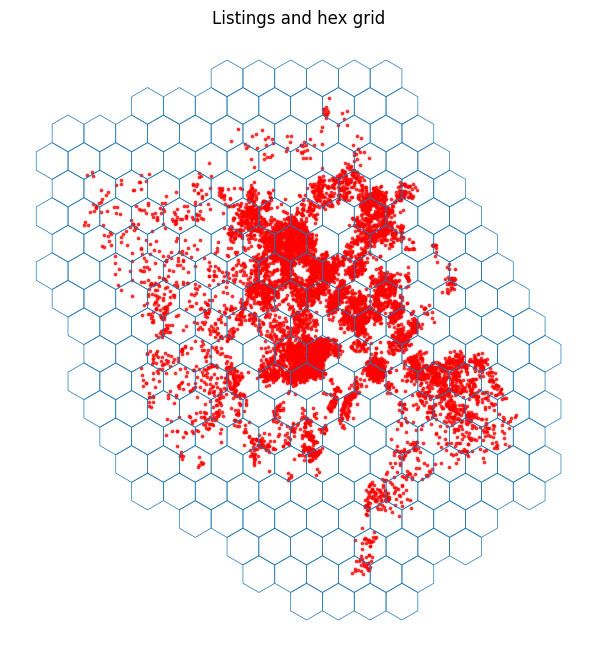

In [49]:
# --- Visualization: check that hexes look like hexes ---

fig, ax = plt.subplots(figsize=(8, 8))

# plot hex outlines
hex_grid.boundary.plot(ax=ax, linewidth=0.5)

# plot listing points
gdf.plot(ax=ax, markersize=3, color="red", alpha=0.7)

ax.set_title("Listings and hex grid")
ax.set_axis_off()
plt.show()

### Mapping hexes

In [50]:
# Sanity check hexbins by projecting on map of Copenhagen

import folium

# Convert hexes and points to WGS84 (lat/lon)
hex_wgs = hex_grid.to_crs(epsg=4326)
pts_wgs = gdf.to_crs(epsg=4326)

center_lat = pts_wgs.geometry.y.mean()
center_lon = pts_wgs.geometry.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.GeoJson(
    hex_wgs,
    name="Hex grid",
    style_function=lambda feature: {
        "fillColor": "none",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(m)

sample_pts = pts_wgs.sample(min(2000, len(pts_wgs)), random_state=0)

#for _, row in sample_pts.iterrows():
for _, row in pts_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

m

In [51]:
# Count unique hexes assigned to the dataset
print("Unique hex_id:",df["hex_id"].nunique())

# Check for missingness
print("Missing in hex_id:",df["hex_id"].isna().sum())

# Drop id, longitude and latitude since they are not needed anymore
df = df.drop(columns=["id", "longitude", "latitude"])

Unique hex_id: 143
Missing in hex_id: 0


## CLEAN UP "price" ATTRIBUTE



In [52]:
# Remove $, commas, and spaces, then convert to numeric
price_clean = (
    df["price"]
    .astype(str)                             # handle existing ints / NA
    .str.replace(r'[\$,]', '', regex=True)   # remove $ and commas
    .str.strip()
)

# Convert to numeric, coercing bad values (like '<NA>') to NaN
price_numeric = pd.to_numeric(price_clean, errors="coerce")

# Store back as nullable integer
df["price"] = price_numeric.astype("Int64")

### VALIDATE PRICE ATTRIBUTE

In [53]:
df["price"].describe()

count         7634.0
mean      1375.48022
std      1178.182905
min            202.0
25%            880.0
50%           1166.0
75%           1600.0
max          63418.0
Name: price, dtype: Float64

The above price statistics seem to be reasonable. For the high and low ends of the spectrum, we spot checked the listings on Airbnb.

## CORRECT DATA TYPES

In [54]:
# -----------------------
# Define column groups
# -----------------------

# Columns that should be treated as categories
cat_cols = [
    "host_response_time",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "hex_id"
]

# Columns that should be treated as integers (Int64)
int_cols = [
    "accommodates",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "availability_30",
    "number_of_reviews",
    "calculated_host_listings_count",
    "description_length",
    "host_about_length",
    "neighborhood_overview_length",
]

# Columns that should be treated as boolean
bool_cols = [
    "description_missing",
    "host_about_missing",
    "host_response_rate_missing",
    "host_acceptance_rate_missing",
    "neighborhood_overview_missing",
    "host_location_missing",
    "amenity_pool",
    "amenity_wifi",
    "amenity_parking",
    "amenity_ac",
    "amenity_kitchen",
    "amenity_hot_tub",
    "amenity_washer",
    "amenity_self_check_in",
    "amenity_tv",
    "amenity_grill",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]

# True floats (allowing decimals)
float_cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "bathrooms",
    "host_tenure_days",
    "price",
]

# -------------------------------------------------
# Make sure beds / bedrooms are ints
# -------------------------------------------------

df["beds"] = df["beds"].round().astype("Int64")
df["bedrooms"] = df["bedrooms"].round().astype("Int64")

# -------------------------------------------------
# 4. Build dtype_map using your preferred pattern
# -------------------------------------------------

dtype_map = {}

# categories
for c in cat_cols:
    dtype_map[c] = "category"

# boolean
for c in bool_cols:
    dtype_map[c] = "boolean"

# ints (nullable)
for c in int_cols:
    dtype_map[c] = "Int64"

# floats
for c in float_cols:
    dtype_map[c] = "float64"

# -----------------------------------
# 5. Apply all conversions in one go
# -----------------------------------

df = df.astype(dtype_map)


## RE-AUDIT THE DATA AFTER CLEANSING

In [55]:
# Run the function to show the various metrics defined

audit_dataframe(df, name="Airbnb Data")


=== AIRBNB DATA AUDIT: Airbnb Data ===

Shape: 9873 rows × 41 columns

---- Missing Values ----


null_count  null_percent    dtype
price        2239         22.68  float64



---- Data Types ----


dtype
host_response_time              category
host_response_rate               float64
host_acceptance_rate             float64
host_is_superhost                boolean
host_has_profile_pic             boolean
host_identity_verified           boolean
neighbourhood_cleansed          category
property_type                   category
room_type                       category
accommodates                       Int64
bathrooms                        float64
bedrooms                           Int64
beds                               Int64
price                            float64
minimum_nights                     Int64
maximum_nights                     Int64
availability_30                    Int64
number_of_reviews                  Int64
instant_bookable                 boolean
calculated_host_listings_count     Int64
description_missing              boolean
description_length                 Int64
host_tenure_days                 float64
host_about_missing               boolean
host_about_length                  Int64
host_response_rate_missing       boolean
host_acceptance_rate_missing     boolean
neighborhood_overview_missing    boolean
neighborhood_overview_length       Int64
host_location_missing            boolean
amenity_pool                     boolean
amenity_wifi                     boolean
amenity_parking                  boolean
amenity_ac                       boolean
amenity_kitchen                  boolean
amenity_hot_tub                  boolean
amenity_washer                   boolean
amenity_self_check_in            boolean
amenity_tv                       boolean
amenity_grill                    boolean
hex_id                          category



---- Descriptive Statistics (Numerical) ----


count        mean          std    min  \
host_response_rate              9873.0    93.28583    17.693986    0.0   
host_acceptance_rate            9873.0   73.753874    26.252576    0.0   
accommodates                    9873.0    3.292312     1.672557    1.0   
bathrooms                       9873.0    1.074294     0.297589    0.0   
bedrooms                        9873.0    1.525777     0.843971    0.0   
beds                            9873.0    1.745265     1.172705    0.0   
price                           7634.0  1375.48022  1178.182905  202.0   
minimum_nights                  9873.0    3.494277     8.501525    1.0   
maximum_nights                  9873.0  279.463385   344.414347    1.0   
availability_30                 9873.0    7.381242      8.62094    0.0   
number_of_reviews               9873.0    30.11263    64.635641    1.0   
calculated_host_listings_count  9873.0     3.84017    20.975539    1.0   
description_length              9873.0  399.244404   145.168016    0.0   
host_tenure_days                9873.0  2965.64013  1304.456727   13.0   
host_about_length               9873.0  105.308113   190.990481    0.0   
neighborhood_overview_length    9873.0  136.630102   255.075688    0.0   

                                   25%     50%     75%      max  
host_response_rate               100.0   100.0   100.0    100.0  
host_acceptance_rate              54.0    81.0   100.0    100.0  
accommodates                       2.0     3.0     4.0     16.0  
bathrooms                          1.0     1.0     1.0      5.0  
bedrooms                           1.0     1.0     2.0      9.0  
beds                               1.0     1.0     2.0     16.0  
price                            880.0  1166.0  1600.0  63418.0  
minimum_nights                     2.0     3.0     4.0    365.0  
maximum_nights                    20.0    90.0   365.0   1125.0  
availability_30                    0.0     4.0    11.0     30.0  
number_of_reviews                  5.0    13.0    31.0   2366.0  
calculated_host_listings_count     1.0     1.0     1.0    247.0  
description_length               309.0   456.0   507.0   1000.0  
host_tenure_days                2193.0  3285.0  3943.0   5961.0  
host_about_length                  0.0     0.0   160.0   6582.0  
neighborhood_overview_length       0.0     0.0   178.0   1000.0



---- Descriptive Statistics (Categorical) ----


count unique                 top  freq
host_response_time      9873      5      within an hour  3877
neighbourhood_cleansed  9873     11             Nrrebro  1792
property_type           9873     45  Entire rental unit  5691
room_type               9873      4     Entire home/apt  8999
hex_id                  9873    143                 166   538



---- Unique Value Counts ----


unique_counts
host_is_superhost                           2
host_has_profile_pic                        2
host_identity_verified                      2
host_location_missing                       2
amenity_wifi                                2
host_about_missing                          2
description_missing                         2
amenity_pool                                2
host_response_rate_missing                  2
host_acceptance_rate_missing                2
neighborhood_overview_missing               2
instant_bookable                            2
amenity_hot_tub                             2
amenity_kitchen                             2
amenity_ac                                  2
amenity_parking                             2
amenity_grill                               2
amenity_tv                                  2
amenity_self_check_in                       2
amenity_washer                              2
room_type                                   4
host_response_time                          5
bedrooms                                    9
bathrooms                                  10
neighbourhood_cleansed                     11
beds                                       15
accommodates                               15
calculated_host_listings_count             24
availability_30                            31
minimum_nights                             38
property_type                              45
host_response_rate                         84
host_acceptance_rate                      100
maximum_nights                            142
hex_id                                    143
number_of_reviews                         330
description_length                        598
host_about_length                         614
neighborhood_overview_length              800
price                                    2033
host_tenure_days                         3764



---- Sample Values ----


host_response_time  host_response_rate  host_acceptance_rate  \
3234  within a few hours               100.0                  53.0   
332       within an hour               100.0                 100.0   
7199             unknown               100.0                  60.0   
3577      within an hour               100.0                  93.0   
5100      within an hour               100.0                 100.0   

      host_is_superhost  host_has_profile_pic  host_identity_verified  \
3234              False                  True                    True   
332               False                  True                    True   
7199              False                  True                    True   
3577               True                  True                    True   
5100              False                  True                   False   

     neighbourhood_cleansed       property_type        room_type  \
3234             Bispebjerg        Entire condo  Entire home/apt   
332                 Nrrebro         Entire loft  Entire home/apt   
7199                Nrrebro        Entire condo  Entire home/apt   
3577              Amager st        Entire condo  Entire home/apt   
5100               Indre By  Entire rental unit  Entire home/apt   

      accommodates  ...  amenity_wifi  amenity_parking  amenity_ac  \
3234             2  ...          True            False       False   
332              4  ...          True            False       False   
7199             4  ...          True            False       False   
3577             4  ...          True            False       False   
5100             4  ...          True             True       False   

      amenity_kitchen  amenity_hot_tub  amenity_washer  amenity_self_check_in  \
3234             True            False            True                  False   
332              True            False            True                  False   
7199             True            False            True                  False   
3577             True            False            True                   True   
5100             True            False            True                  False   

      amenity_tv  amenity_grill  hex_id  
3234        True          False     179  
332         True          False     136  
7199        True          False     166  
3577        True           True     110  
5100        True          False     157  

[5 rows x 41 columns]



---- Boolean Column Distributions ----


column    dtype  true_count  false_count  na_count  \
0               host_is_superhost  boolean        2168         7705         0   
1            host_has_profile_pic  boolean        9578          295         0   
2          host_identity_verified  boolean        8986          887         0   
3                instant_bookable  boolean        1068         8805         0   
4             description_missing  boolean         176         9697         0   
5              host_about_missing  boolean        5674         4199         0   
6      host_response_rate_missing  boolean         852         9021         0   
7    host_acceptance_rate_missing  boolean         124         9749         0   
8   neighborhood_overview_missing  boolean        6386         3487         0   
9           host_location_missing  boolean        1582         8291         0   
10                   amenity_pool  boolean          64         9809         0   
11                   amenity_wifi  boolean        9652          221         0   
12                amenity_parking  boolean        1162         8711         0   
13                     amenity_ac  boolean         262         9611         0   
14                amenity_kitchen  boolean        9573          300         0   
15                amenity_hot_tub  boolean          47         9826         0   
16                 amenity_washer  boolean        8936          937         0   
17          amenity_self_check_in  boolean        3999         5874         0   
18                     amenity_tv  boolean        7511         2362         0   
19                  amenity_grill  boolean        2191         7682         0   

    true_percent  false_percent  na_percent  
0          21.96          78.04         0.0  
1          97.01           2.99         0.0  
2          91.02           8.98         0.0  
3          10.82          89.18         0.0  
4           1.78          98.22         0.0  
5          57.47          42.53         0.0  
6           8.63          91.37         0.0  
7           1.26          98.74         0.0  
8          64.68          35.32         0.0  
9          16.02          83.98         0.0  
10          0.65          99.35         0.0  
11         97.76           2.24         0.0  
12         11.77          88.23         0.0  
13          2.65          97.35         0.0  
14         96.96           3.04         0.0  
15          0.48          99.52         0.0  
16         90.51           9.49         0.0  
17         40.50          59.50         0.0  
18         76.08          23.92         0.0  
19         22.19          77.81         0.0



---- Categorical Cardinality ----


column  unique_values
0      host_response_time              5
1  neighbourhood_cleansed             11
2           property_type             45
3               room_type              4
4                  hex_id            143



---- Duplicate Rows ----


duplicate_rows
0               0



=== END AUDIT ===



Everything looks good except for the "price" attribute missingness. The next section will address this.

## CREATE TWO DATAFRAMES WITH DIFFERENT "price" APPROACHES

In [56]:
# Create two new dataframes to split between approaches (dropping missing prices vs. imputing missing prices)
df_impute_missing_price = df.copy()
df_drop_missing_price = df.copy()

median_price = df["price"].median()
df_impute_missing_price["price"] = df_impute_missing_price["price"].fillna(median_price).astype("Int64")

df_drop_missing_price = df_drop_missing_price.dropna(subset=["price"])

print("\"df_impute_missing_price\" shape:", df_impute_missing_price.shape)
print("\"df_drop_missing_price\" shape:", df_drop_missing_price.shape)

"df_impute_missing_price" shape: (9873, 41)
"df_drop_missing_price" shape: (7634, 41)


In [57]:
# Create a dictionary with the two split datasets.
# Instead of rewriting the pipeline for each version, we can loop over the dataset dictionary and train/evaluate all models on all variants cleanly.

datasets = {
    "dropped_missing_prices": df_drop_missing_price,
    "imputed_missing_prices": df_impute_missing_price
}

print(type(datasets))
for name, df in datasets.items():
    print(name, type(df))

<class 'dict'>
dropped_missing_prices <class 'pandas.core.frame.DataFrame'>
imputed_missing_prices <class 'pandas.core.frame.DataFrame'>


# TRAIN/TEST SPLIT AND PREPROCESSING

In [58]:
# For now, we are building and debugging the pipeline on only one of the datasets. Later, we will use both datasets.

df = datasets["dropped_missing_prices"]

# ======================================
# DEFINE TARGET (y) AND FEATURES (X)
# ======================================

target_col = "availability_30"

# X = all columns except the target
X = df.drop(columns=[target_col])

# y = the target column
y = df[target_col]


# ===============================================
# TRAIN / TEST SPLIT (BEFORE ANY PREPROCESSING)
# ===============================================

# We split the data into:
# - Training set (used to fit/learn the model - we will perform cross validation within the training set)
# - Test set (a hold-out to evaluate final performance)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


# ============================================
# IDENTIFY NUMERIC, BOOLEAN, AND CATEGORICAL FEATURES
# ============================================

boolean_features = X_train.select_dtypes(include="boolean").columns.tolist()
numeric_features = (
    X_train
    .select_dtypes(include=["float64", "Int64"])
    .columns
    .difference(boolean_features)
    .tolist()
)
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()

print("Boolean features:", boolean_features)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ===================================================
# SET UP PREPROCESSING STEPS
# ===================================================

# - Numeric features: StandardScaler
# - Boolean features: "passthrough" (keep 0/1 as-is)
# - Categorical features: OneHotEncoder
#
# This "preprocessor" will later be plugged into a Pipeline
# together with a model (e.g., Ridge, RandomForest, KNN).

preprocessor = ColumnTransformer(
    transformers=[
        # ("name_for_step", transformer_object, list_of_columns)
        ("num", StandardScaler(), numeric_features),
        ("bool", "passthrough", boolean_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

print("\nPreprocessing setup complete.\n")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Boolean features: {len(boolean_features)}")
print(f"  Categorical features: {len(categorical_features)}")

Boolean features: ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'description_missing', 'host_about_missing', 'host_response_rate_missing', 'host_acceptance_rate_missing', 'neighborhood_overview_missing', 'host_location_missing', 'amenity_pool', 'amenity_wifi', 'amenity_parking', 'amenity_ac', 'amenity_kitchen', 'amenity_hot_tub', 'amenity_washer', 'amenity_self_check_in', 'amenity_tv', 'amenity_grill']
Numeric features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count', 'description_length', 'host_about_length', 'host_acceptance_rate', 'host_response_rate', 'host_tenure_days', 'maximum_nights', 'minimum_nights', 'neighborhood_overview_length', 'number_of_reviews', 'price']
Categorical features: ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'hex_id']

Preprocessing setup complete.

  Numeric features: 15
  Boolean features: 20
  Categorical features: 5


# ESTABLISH BASELINES (CREATE FUNCTION TO RUN MODELS)

In [59]:
from sklearn.dummy import DummyRegressor

# The following function wraps the given model in a pipeline with the
# preprocessor and evaluates it with cross-validation on the training
# data. No test-set evaluation happens here to prevents leakage.

def evaluate_model(model, model_name):

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ])

   # --- CV MAE ---
    cv_mae_scores = -cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error"
    )
    cv_mae_mean = cv_mae_scores.mean()

    # --- CV RMSE ---
    cv_rmse_scores = np.sqrt(
        -cross_val_score(
            pipe,
            X_train,
            y_train,
            cv=5,
            scoring="neg_mean_squared_error"
        )
    )
    cv_rmse_mean = cv_rmse_scores.mean()

    # --- CV R² ---
    cv_r2_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring="r2"
    )
    cv_r2_mean = cv_r2_scores.mean()

    print(f"\n=== {model_name} (CV Only) ===")
    print(f"CV MAE:  {cv_mae_mean:.3f}")
    print(f"CV RMSE: {cv_rmse_mean:.3f}")
    print(f"CV R²:   {cv_r2_mean:.3f}")

    return {
        "model": model_name,
        "cv_mae": cv_mae_mean,
        "cv_rmse": cv_rmse_mean,
        "cv_r2": cv_r2_mean,
    }

In [ ]:
# 1) Baseline: predict the mean availability
baseline_results = evaluate_model(
    DummyRegressor(strategy="mean"),
    "DummyRegressor (mean)"
)


=== DummyRegressor (mean) (CV Only) ===
CV MAE:  7.439
CV RMSE: 8.959
CV R²:   -0.001


These results tell us that if we always predict the mean 30-day availability for a new listing, the average error will be 7.439 days (in either direction). The RSME is higher (8.959) because the model makes some larger errors, which are punished more aggresively. The R² of 0 makes sense, since the model explains none of the variance in the data.

In [60]:
# 2) Simple Linear Regression
linreg_results = evaluate_model(
    LinearRegression(),
    "LinearRegression"
)


=== LinearRegression (CV Only) ===
CV MAE:  6.922
CV RMSE: 8.550
CV R²:   0.088


This simple regression model improved the MAE (that is, how many days on average the model is off by) by 0.52. The RMSE is slightly better at 8.55. The R² value is barely above 0, meaning that this model is slightly better at predicting the target variable than just predicting the mean. *This indicates that our data has a very weak linear pattern.*

In [61]:
# 3) Decision Tree (nonlinear, baseline settings)
dt_results = evaluate_model(
    DecisionTreeRegressor(random_state=42),
    "DecisionTreeRegressor"
)


=== DecisionTreeRegressor (CV Only) ===
CV MAE:  8.414
CV RMSE: 11.295
CV R²:   -0.592


The decision tree is worse for all metrics. The R² value is also negative, meaning it is worse at predicting the 30-day availability than just predicting the mean. **This estimator is probably not worth pursuing further.**

In [62]:
# 4) Random Forest (nonlinear ensemble)
rf_results = evaluate_model(
    RandomForestRegressor(
        n_estimators=30,
        random_state=42
    ),
    "RandomForestRegressor"
)


=== RandomForestRegressor (CV Only) ===
CV MAE:  6.631
CV RMSE: 8.290
CV R²:   0.143


This is stronger than the baseline and linear regression, but the R² is still quite bad (only ~14% of the variance explained) and the average prediction is still off by 6.6 days.

In [63]:
# 5) Gradient Boosting (strong nonlinear model)
gbr_results = evaluate_model(
    GradientBoostingRegressor(
        random_state=42,
        learning_rate=0.1,
        n_estimators=30
    ),
    "GradientBoostingRegressor"
)


=== GradientBoostingRegressor (CV Only) ===
CV MAE:  6.768
CV RMSE: 8.231
CV R²:   0.155


This model performed best in terms of variance explained (R² = 0.155), and the MAE isn't much worse than random forest.

In [64]:
# 6) KNN (instance-based model)
knn_results = evaluate_model(
    KNeighborsRegressor(n_neighbors=5),
    "KNeighborsRegressor (k=5)"
)


=== KNeighborsRegressor (k=5) (CV Only) ===
CV MAE:  7.221
CV RMSE: 9.115
CV R²:   -0.036


The R² is negative (-0.036) and RMSE is worse than the baseline. **This estimator is probably not worth pursuing further.**

# DEFINE THE MODELS AND ASSOCIATED HYPERPARAMETERS SO WE CAN FIND THE BEST COMBINATION USING GRIDSEARCHCV

In [65]:
# ==========================================
# DEFINE MODELS AND THEIR PARAMETER GRIDS BASED ON PRELIMINARY RESULTS ABOVE
# ==========================================

# We create a dictionary where:
# - The key (e.g., "ridge") is just a name we choose for the model
# - The value holds:
#     - "estimator": the actual sklearn model object
#     - "param_grid": a dictionary of hyperparameters to explore for that model
#
# IMPORTANT:
# When we plug a model into a Pipeline with the step name "model",
# we must prefix hyperparameter names with "model__" so GridSearchCV
# knows which step in the pipeline they belong to.

models_config = {
    "linear_regression": {
        "estimator": LinearRegression(),
        "param_grid": {} # No hyperparameters for linear regression
    },
    "ridge": {
        "estimator": Ridge(random_state=42),   # Ridge regression (L2 regularization)
        "param_grid": {
            # alpha controls the strength of regularization:
            # - small alpha: weak regularization (closer to plain linear regression)
            # - large alpha: stronger shrinkage of coefficients
            "model__alpha": [0.1, 1.0, 10.0]
        }
    },
    "lasso": {
        "estimator": Lasso(random_state=42),   # Lasso regression (L1 regularization)
        "param_grid": {
            # L1 can drive some coefficients exactly to zero (feature selection)
            "model__alpha": [0.01, 0.1, 1.0]
        }
    },
    "random_forest": {
        "estimator": RandomForestRegressor(
            random_state=42
        ),
        "param_grid": {
            # n_estimators: number of trees in the forest
            "model__n_estimators": [100, 200],     # Reasonable, not too big for project
            # max_depth: how deep each individual tree can grow (controls overfitting)
            "model__max_depth": [5, 10, 20],
            # min_samples_leaf: minimum samples in a leaf node (controls overfitting)
            "model__min_samples_leaf": [5, 10, 20]
        }
    },
    "GradientBoosting": {
        "estimator": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.1],
        }
  }
}

# LOOP OVER EACH MODEL IN THE CONFIG DICTIONARY ABOVE AND RUN GRIDSEARCHCV TO ESTABLISH THE BEST COMBINATION OF HYPERPARAMETERS

In [ ]:
# ============================================
# LOOP OVER MODELS: BUILD PIPELINE + TUNE IT
# ============================================

results = []          # store a summary of results for each model in this list
best_estimators = {}  # store the refit best pipeline per model

# We use the same primary evaluation metric for all models:
# - MAE (Mean Absolute Error) as scoring metric in CV
#   (in sklearn, higher scores are better, so we use "neg_mean_absolute_error")
scoring_metric = "neg_mean_absolute_error"

for name, cfg in models_config.items():
    print(f"\n======================")
    print(f"Running GridSearch for: {name}")
    print(f"======================")

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", cfg["estimator"])
    ])

    # GridSearchCV will:
    # - try all combinations of hyperparameters in cfg["param_grid"]
    # - for each combination, perform cross-validation (cv=5 splits)
    # - use the scoring metric (negative MAE) to rank combinations
    # - keep track of the best combination found

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=cfg["param_grid"],
        cv=5,                                            # uses 5-fold cross-validation
        scoring=scoring_metric,                          # "neg_mean_absolute_error"
        verbose=1                                        # print progress
    )

    grid_search.fit(X_train, y_train)                    # runs gridsearch to test all combinations of hyperparameters

    print("Best hyperparameters found (CV):")
    print(grid_search.best_params_)

    # best_score_ is NEGATIVE MAE (because sklearn maximizes scores),
    # so we multiply by -1 to get the actual MAE.
    best_cv_mae = -grid_search.best_score_
    print(f"Best CV MAE: {best_cv_mae:.3f}")

    results.append({                                    # the results array we defined before the loop to store the best parameters for each estimator
        "name": name,
        "best_cv_mae": best_cv_mae,
        "best_params": grid_search.best_params_,
    })

    best_estimators[name] = grid_search.best_estimator_  # refit on full training set


Running GridSearch for: linear_regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters found (CV):
{}
Best CV MAE: 6.922

Running GridSearch for: ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters found (CV):
{'model__alpha': 10.0}
Best CV MAE: 6.881

Running GridSearch for: lasso
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters found (CV):
{'model__alpha': 0.01}
Best CV MAE: 6.875

Running GridSearch for: random_forest
Fitting 5 folds for each of 18 candidates, totalling 90 fits


These results are quite bad. The data is likely too noisy, and the target variable is inherently problematic.

**Note to self - I'm going to replicate everything in a separate notebook and use the price as the target. Although the price attribute also possesses issues, we can make the assumption that other Airbnb renters are setting prices reasonably, such that they can rent out their properties more successfully.**

# TRY PCA FOR THE LINEAR MODELS (DOES NOT HELP FOR TREE-BASED MODELS)

# RANK THE MODELS BASED ON CV RESULTS AND CHOOSE THE BEST MODEL FOR FINAL TEST SET ANALYSIS

In [ ]:
# =======================================
# CREATE SUMMARY TABLE OF MODEL RESULTS
# =======================================

# Convert the list of result dicts into a DataFrame.
# Each row corresponds to one model (linear regression, ridge, lasso, RF, GB)
results_df = pd.DataFrame(results)

# Sort models by their CV MAE (lower is better performance).
# We reset the index so the top model becomes row 0.
results_df = (
    results_df
    .sort_values(by="cv_mae", ascending=True)
    .reset_index(drop=True)
)

print("\n===== MODEL COMPARISON (by CV MAE — lower is better) =====")
display(results_df)

In [ ]:
# =======================================
# SELECT THE BEST MODEL BASED ON CV MAE
# =======================================

# Extract the name of the best model (row 0 after sorting)
best_model_name = results_df.loc[0, "model"]

# Retrieve the already-refit best estimator from storage.
# IMPORTANT: GridSearchCV has already refit this best estimator
# on the FULL training data using the best hyperparameters.
final_model = best_estimators[best_model_name]

print(f"\nBest model chosen based on CV MAE: {best_model_name}")
print("This model is already refit on the full training set (via GridSearchCV).")

# =======================================
# EVALUATE THE BEST MODEL ON THE TEST SET
# =======================================

# Use the final model to generate predictions for the held-out test set.
y_pred_test = final_model.predict(X_test)

# Compute evaluation metrics on the test set.
test_mae = mean_absolute_error(y_test, y_pred_test)     # average magnitude of error
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  # penalizes large errors
test_r2 = r2_score(y_test, y_pred_test)                 # % variance explained

# Create a DataFrame for clean formatted display of test metrics.
test_results_df = pd.DataFrame({
    "Test MAE":  [test_mae],
    "Test RMSE": [test_rmse],
    "Test R²":   [test_r2],
}, index=[best_model_name])

print("\n===== FINAL TEST PERFORMANCE (held-out) =====")
display(test_results_df)